# Distillbert Fine-Tune Model (Balanced_Data)

We will fine tune:
- Learning Rate to `5e-5`
- Optimizer to Adam
- max_length to `256`
- batch size to `16`

## Iport Libraries

In [1]:
# Common Python Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import Adam

# Data Preprocessing
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sklearn.preprocessing import OrdinalEncoder

# Model Metrics
from sklearn.metrics import classification_report, confusion_matrix

project_path = "../"
SEED = 42

model_name = "distilbert-base-uncased"

/home/andrew/miniconda3/envs/hugging-face-torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Choose Device

In [2]:
# Detect available device
if torch.cuda.is_available():
    # check if ROCm backend is active
    if torch.version.hip is not None:
        backend = "ROCm"
    else:
        backend = "CUDA"

    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Backend: {backend}")
else:
    device = torch.device("cpu")
    print("PyTorch is not using GPU — running on CPU")

PyTorch is using GPU: AMD Radeon Graphics
Backend: ROCm


In [3]:
device = torch.device('cpu') #cant use gpu sadly after an attempt

## Import Data

In [4]:
tweets_data_path = os.path.join(project_path, "data/cleaned_data.csv")
tweets_data = pd.read_csv(tweets_data_path, sep = ",")

In [5]:
tweets_data.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,length,clean_text
0,0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),4,What said.
1,1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),9,plus you've added commercials to the experienc...
2,2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),12,I didn't today... Must mean I need to take ano...
3,3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),17,"it's really aggressive to blast obnoxious ""ent..."
4,4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),10,and it's a really big bad thing about it


## Split the data to Train, Test, and Validation

In [6]:
test_size = 0.20
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(tweets_data, test_size=test_size, random_state=SEED)

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=SEED)

In [7]:
# # Split to x and y values
x_train = train_df[["clean_text"]]
y_train = train_df[["airline_sentiment"]]

x_test = test_df["clean_text"].tolist()
y_test = test_df[["airline_sentiment"]]

x_val = val_df["clean_text"].tolist()
y_val = val_df[["airline_sentiment"]]


## Balancing The Data

In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random under sampling
rus = RandomUnderSampler(random_state=SEED)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

# convert to list for model input
x_train_rus = x_train_rus["clean_text"].to_list()

### Difference of before rebalance and after rebalance

Text(0.5, 1.0, 'Class Distribution (Before Rebalance)')

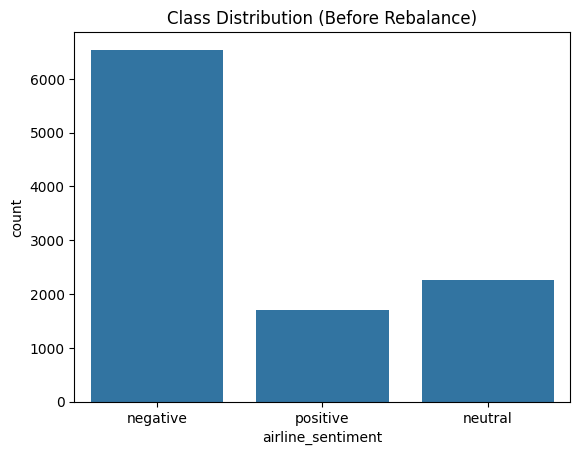

In [9]:
sns.countplot(x="airline_sentiment",data = y_train)
plt.title("Class Distribution (Before Rebalance)")

Text(0.5, 1.0, 'Class Distribution (After Rebalance)')

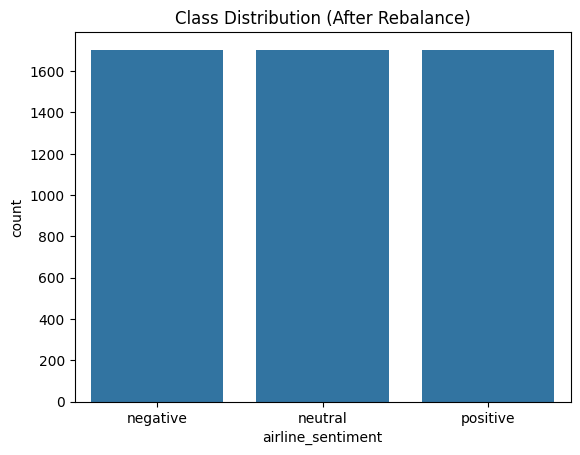

In [10]:
sns.countplot(x="airline_sentiment",data = y_train_rus)
plt.title("Class Distribution (After Rebalance)")

## Data Preprocessing

### Encoding the Y Values

In [11]:
y_ord_enc = OrdinalEncoder(categories=[["negative", "neutral", "positive"]])

y_train_rus = y_ord_enc.fit_transform(y_train_rus).flatten()
y_test = y_ord_enc.transform(y_test).flatten()
y_val = y_ord_enc.transform(y_val).flatten()

### Tokenizer for the text

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

class sentiment_text(torch.utils.data.Dataset): # create a class that behaves like torch.utils.data.Dataset
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer( # converts raw text -> model input
                                    texts,
                                    truncation = True,
                                    padding = True,
                                    max_length = 256 # Fine Tune
                                )
        
        # get the labels
        self.labels = labels

    def __getitem__(self, index): # so that pytorch can get the data (returns one sample of the data)
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()} # self.encoding stores (input_ids, attention_mask, label)
        item["labels"] = torch.tensor(self.labels[index], dtype=torch.long) # get the label on the chosen index while converting to a torch tensor format
        return item
    
    def __len__(self): #to get the length of the data (used when batching)
        return len(self.labels)

In [13]:
train_dataset = sentiment_text(x_train_rus, y_train_rus, tokenizer)
test_dataset  = sentiment_text(x_test, y_test, tokenizer)
val_dataset  = sentiment_text(x_val, y_val, tokenizer)

### Data Loader for the Model

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16)
val_loader  = DataLoader(val_dataset, batch_size=16)

## Train Baseline Model

In [15]:
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3 # sinc there is positive, negative, Neutral
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = Adam(model.parameters(), lr=5e-5)

In [ ]:
model.to(device)
model.train() #make the model to training mode

for epoch in tqdm(range(3), desc="Training Distillbert Model", unit="epoch"):  # number of epochs
    
    for batch in train_loader:
        for k, v in batch.items():
            batch[k] = v.to(device)

        optimizer.zero_grad() # Resets all gradients to zero before computing new ones.
        outputs = model(**batch)  # forward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} loss: {loss.item()}")

Training Distillbert Model:  10%|█         | 1/10 [02:43<24:31, 163.52s/epoch]

Epoch 1 loss: 1.016564130783081


Training Distillbert Model:  20%|██        | 2/10 [05:26<21:44, 163.10s/epoch]

Epoch 2 loss: 1.097632646560669


Training Distillbert Model:  30%|███       | 3/10 [08:09<19:03, 163.30s/epoch]

Epoch 3 loss: 1.0896294116973877


Training Distillbert Model:  40%|████      | 4/10 [10:52<16:18, 163.04s/epoch]

Epoch 4 loss: 1.1303788423538208


Training Distillbert Model:  50%|█████     | 5/10 [13:35<13:35, 163.05s/epoch]

Epoch 5 loss: 1.0951831340789795


Training Distillbert Model:  60%|██████    | 6/10 [16:17<10:50, 162.67s/epoch]

Epoch 6 loss: 1.1044659614562988


Training Distillbert Model:  70%|███████   | 7/10 [19:01<08:09, 163.13s/epoch]

Epoch 7 loss: 1.0986188650131226


Training Distillbert Model:  80%|████████  | 8/10 [21:43<05:25, 162.88s/epoch]

Epoch 8 loss: 1.0986436605453491


Training Distillbert Model:  90%|█████████ | 9/10 [24:25<02:42, 162.55s/epoch]

Epoch 9 loss: 1.098897933959961


Training Distillbert Model: 100%|██████████| 10/10 [27:10<00:00, 163.06s/epoch]

Epoch 10 loss: 1.0980578660964966


## Model Evaluation

In [18]:
model.eval()  # set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # no gradients needed
    for batch in test_loader:
        # move data to device (CPU or GPU)
        for k, v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        logits = outputs.logits  # raw predictions
        
        preds = torch.argmax(logits, dim=1)  # pick class with highest score
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

In [19]:
labels = np.array(all_labels)
preds = np.array(all_preds)

In [20]:
print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"], zero_division=0))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1880
     neutral       0.00      0.00      0.00       582
    positive       0.16      1.00      0.27       459

    accuracy                           0.16      2921
   macro avg       0.05      0.33      0.09      2921
weighted avg       0.02      0.16      0.04      2921



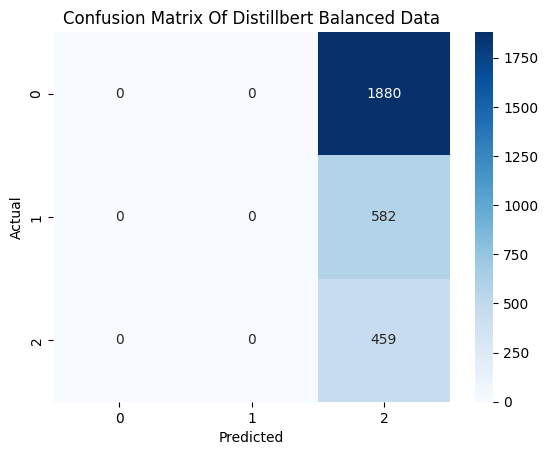

In [22]:
cm = confusion_matrix(labels, preds)

sns.heatmap(
    cm,
    cmap= "Blues",
    annot= True,
    fmt= "g"
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of Distillbert Balanced Data")

plt.show()